In [1]:
import os 
import pandas as pd
import requests
import matplotlib.pyplot as plt
import requests
from pprint import pprint
import gmaps
from statsmodels.formula.api import ols
from config import Api_Key

In [2]:
# Configure gmaps
gmaps.configure(api_key=Api_Key)

In [3]:
file = "Resources/Road_Crashes_for_five_Years_-_Victoria.csv"

main_df = pd.read_csv(file)

main_df.head()


,X,Y,objectid,accident_no,abs_code,accident_status,accident_date,date_value,Daily_Rainfall,accident_time,...,deg_urban_all,lga_name_all,region_name_all,srns,srns_all,rma,rma_all,divided,divided_all,stat_div_name
0,2498217.170,2454870.252,1,T20140013514,ABS to receive accident,Unfinished,1/7/2014,41821,0.6,13:09:00,...,TOWNS,MITCHELL,NORTHERN REGION,B,B,Arterial Highway,"Local Road,Arterial Highway",Undivided,Undivided,Country
1,2502934.960,2423005.289,2,T20140013549,ABS to receive accident,Finished,2/7/2014,41822,0.0,0:01:00,...,MELB_URBAN,WHITTLESEA,METROPOLITAN NORTH WEST REGION,NaN,NaN,Arterial Other,Arterial Other,Undivided,Undivided,Metro
2,2520154.039,2395621.674,3,T20140013561,ABS to receive accident,Finished,2/7/2014,41822,0.0,8:30:00,...,MELB_URBAN,KNOX,METROPOLITAN SOUTH EAST REGION,NaN,NaN,Local Road,Local Road,Undivided,Undivided,Metro
3,2473719.463,2402357.319,4,T20140013563,ABS to receive accident,Finished,2/7/2014,41822,0.0,10:08:00,...,MELB_URBAN,WYNDHAM,METROPOLITAN NORTH WEST REGION,C,C,Arterial Other,"Arterial Other,Local Road",Divided,"Undivided,Divided",Metro
4,2484073.998,2409123.682,5,T20140013567,ABS to receive accident,Finished,2/7/2014,41822,0.0,9:12:00,...,MELB_URBAN,WYNDHAM,METROPOLITAN NORTH WEST REGION,NaN,NaN,Arterial Other,"Arterial Other,Local Road",Undivided,Undivided,Metro


In [4]:
#Print a list of columns, so we can find out which column we need
print(main_df.columns.tolist())

['X', 'Y', 'objectid', 'accident_no', 'abs_code', 'accident_status', 'accident_date', 'date_value', 'Daily_Rainfall', 'accident_time', 'alcoholtime', 'accident_type', 'day_of_week', 'dca_code', 'hit_run_flag', 'light_condition', 'police_attend', 'road_geometry', 'severity', 'speed_zone', 'run_offroad', 'node_id', 'longitude', 'latitude', 'node_type', 'lga_name', 'region_name', 'vicgrid_x', 'vicgrid_y', 'total_persons', 'inj_or_fatal', 'fatality', 'seriousinjury', 'otherinjury', 'noninjured', 'males', 'females', 'bicyclist', 'passenger', 'driver', 'pedestrian', 'pillion', 'motorist', 'unknown', 'ped_cyclist_5_12', 'ped_cyclist_13_18', 'old_pedestrian', 'old_driver', 'young_driver', 'alcohol_related', 'unlicencsed', 'no_of_vehicles', 'heavyvehicle', 'passengervehicle', 'motorcycle', 'publicvehicle', 'deg_urban_name', 'deg_urban_all', 'lga_name_all', 'region_name_all', 'srns', 'srns_all', 'rma', 'rma_all', 'divided', 'divided_all', 'stat_div_name']


In [5]:
#Created a new DataFrame, and took out some of the columns. 
#Feel free to delete more, I didn't limit the columns to our discussed topics, as there maybe more ideas later and we may use the extra columns

crash_df = main_df[['accident_no',  'accident_date', 'date_value', 
                      'Daily_Rainfall', 'accident_time', 'alcoholtime', 
                      'accident_type', 'day_of_week', 'dca_code', 
                      'hit_run_flag', 'light_condition', 'police_attend', 
                      'road_geometry', 'severity', 'speed_zone', 
                      'run_offroad', 'longitude', 'latitude', 
                      'lga_name', 'region_name', 'total_persons', 
                      'inj_or_fatal', 'fatality', 'seriousinjury', 
                      'otherinjury', 'noninjured', 
                      'males', 'females',  
                      'alcohol_related','stat_div_name']]

In [6]:
#Display the dataframe
crash_df.head()

,accident_no,accident_date,date_value,Daily_Rainfall,accident_time,alcoholtime,accident_type,day_of_week,dca_code,hit_run_flag,...,total_persons,inj_or_fatal,fatality,seriousinjury,otherinjury,noninjured,males,females,alcohol_related,stat_div_name
0,T20140013514,1/7/2014,41821,0.6,13:09:00,No,Collision with vehicle,Monday,RIGHT THROUGH,No,...,4.0,1.0,0.0,0.0,1.0,3.0,1.0,3.0,No,Country
1,T20140013549,2/7/2014,41822,0.0,0:01:00,Yes,Collision with vehicle,Wednesday,U TURN,No,...,4.0,3.0,0.0,0.0,3.0,1.0,0.0,3.0,No,Metro
2,T20140013561,2/7/2014,41822,0.0,8:30:00,No,collision with some other object,Wednesday,STRUCK OBJECT ON CARRIAGEWAY,No,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,No,Metro
3,T20140013563,2/7/2014,41822,0.0,10:08:00,No,Collision with vehicle,Wednesday,CROSS TRAFFIC(INTERSECTIONS ONLY),Yes,...,3.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,No,Metro
4,T20140013567,2/7/2014,41822,0.0,9:12:00,No,Collision with vehicle,Wednesday,RIGHT THROUGH,No,...,2.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,No,Metro


In [7]:
#---------Proposed topics---------
#-       Suburb vs accident numbers, display on Gmap (AJ)
#-       Days of the week vs Accident numbers (SK)
#-       Number of accident vs suburb (AJ)
#-       Number of accident vs Region 
#-       Light condition (groupby) vs number of accident... 
#                 -what else could be closely related to light condition (Corrolation/Linea regression)
#-       Nearest hospital vs suburbs that have the highest accident (Google Place API, Gmap) (JD)
#-       Multi-line plot for Type of accident, over the 5 years (AJ)
#-       Alcohol vs Dead end ["road_geometry"] (for fun!) (KK)
#-       Rainfall vs accident numbers (SK)
#-       Rainfall vs hit and run (KK)

In [8]:
#-----Jing's Part-------

In [9]:
#-       Nearest medical centre vs suburbs that have the highest accident (Google Place API, Gmap) (JD)

In [10]:
#Create a new Dataframe for Jing's part of analayst, so it's not going to affect other team members work
suburb_df = crash_df[['accident_no',  'accident_date', 'date_value', 
                      'accident_type',  'dca_code', 
                      'light_condition','longitude', 'latitude', 
                      'lga_name', 'region_name']]

In [11]:
#Remove rows without Longitude and Latitude (including those with "-1" value)
suburb_df_LatLng_cleaned = suburb_df.dropna()
suburb_df_LatLng_cleaned = suburb_df_LatLng_cleaned.loc[(suburb_df_LatLng_cleaned["longitude"] != -1)]

In [12]:
suburb_df_LatLng_cleaned.head()

,accident_no,accident_date,date_value,accident_type,dca_code,light_condition,longitude,latitude,lga_name,region_name
0,T20140013514,1/7/2014,41821,Collision with vehicle,RIGHT THROUGH,Day,144.979861,-37.406699,MITCHELL,NORTHERN REGION
5,T20140013582,2/7/2014,41822,Collision with a fixed object,OFF RIGHT BEND INTO OBJECT/PARKED VEHICLE,Day,144.962062,-37.842131,PORT PHILLIP,METROPOLITAN NORTH WEST REGION
6,T20140013503,1/7/2014,41821,Collision with vehicle,CROSS TRAFFIC(INTERSECTIONS ONLY),Day,144.904287,-37.753077,MOONEE VALLEY,METROPOLITAN NORTH WEST REGION
7,T20140013532,1/7/2014,41821,Collision with vehicle,REAR END(VEHICLES IN SAME LANE),Dusk/Dawn,145.273192,-38.006269,CASEY,METROPOLITAN SOUTH EAST REGION
8,T20140013578,2/7/2014,41822,Collision with vehicle,CROSS TRAFFIC(INTERSECTIONS ONLY),Day,142.161220,-34.189796,MILDURA,WESTERN REGION


In [13]:
#Create new dataframe for City vs Number of Accidents
suburb_accid_df = pd.DataFrame(suburb_df_LatLng_cleaned["lga_name"].value_counts())
suburb_accid_df=suburb_accid_df.rename(columns = {"lga_name" : "Number of Accident"})

In [14]:
suburb_accid_df.head(50)

,Number of Accident
MELBOURNE,3803
CASEY,3005
GEELONG,2875
DANDENONG,2399
HUME,2396
BRIMBANK,2181
WHITTLESEA,2172
YARRA RANGES,2147
MONASH,2142
MORELAND,2005


In [15]:
#Add Latitude and Longitude of the cities
suburb_accid_df["Latitude"] = ""
suburb_accid_df["Longitude"] = ""
suburb_accid_df["Closest Medical Centre"] = ""
suburb_accid_df["Address"]=""

In [16]:
#Display the new dataframe
suburb_accid_df.head(100)

,Number of Accident,Latitude,Longitude,Closest Medical Centre,Address
MELBOURNE,3803,,,,
CASEY,3005,,,,
GEELONG,2875,,,,
DANDENONG,2399,,,,
HUME,2396,,,,
...,...,...,...,...,...
MOUNT HOTHAM ALPINE RESOR,2,,,,
MOUNT BULLER ALPINE RESOR,2,,,,
(MOUNT STIRLING),2,,,,
(FRENCH ISLAND),2,,,,


In [17]:
#Reset Index and create a list of City Names, with Victoria and AU
suburb_accid_df= suburb_accid_df.reset_index().copy()
city = suburb_accid_df["index"]+",Victoria,AU"

In [18]:
#Loop throught the city names, and call GeoCode to return Latitude and Longtitude, then put into the datafram
index1=0
for x in city:
    
    # Build the endpoint URL
    target_url = ('https://maps.googleapis.com/maps/api/geocode/json?''address={0}&key={1}').format(x, Api_Key)
    
    geo_data = requests.get(target_url).json()
    
    results = geo_data["results"]
    
    suburb_accid_df.loc[index1, "Latitude"] = results[0]["geometry"]["location"]["lat"]
    suburb_accid_df.loc[index1, "Longitude"] = results[0]["geometry"]["location"]["lng"]
    index1+=1

In [19]:
#Display the dataframe
suburb_accid_df.head(10)

,index,Number of Accident,Latitude,Longitude,Closest Medical Centre,Address
0,MELBOURNE,3803,-37.8136,144.963,,
1,CASEY,3005,-38.1105,145.292,,
2,GEELONG,2875,-38.1499,144.362,,
3,DANDENONG,2399,-37.9848,145.214,,
4,HUME,2396,-37.5987,144.829,,
5,BRIMBANK,2181,-37.7595,144.807,,
6,WHITTLESEA,2172,-37.5139,145.114,,
7,YARRA RANGES,2147,-37.7451,145.713,,
8,MONASH,2142,-37.9016,145.116,,
9,MORELAND,2005,-37.7241,144.95,,


In [20]:
locations = suburb_accid_df[["Latitude", "Longitude"]]
weights = suburb_accid_df["Number of Accident"]/500

In [21]:
# Plot Heatmap to show the hotspots in Victoria
fig = gmaps.figure(map_type="TERRAIN")

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=weights, 
                                 dissipating=False, max_intensity=2,
                                 point_radius=0.015)

#Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [22]:
#Create a new Dataframe to find out the top 10 cities with most number of accidents
first_10_df = suburb_accid_df.head(10).copy()
first_10_city_df = first_10_df[["index", "Number of Accident"]]

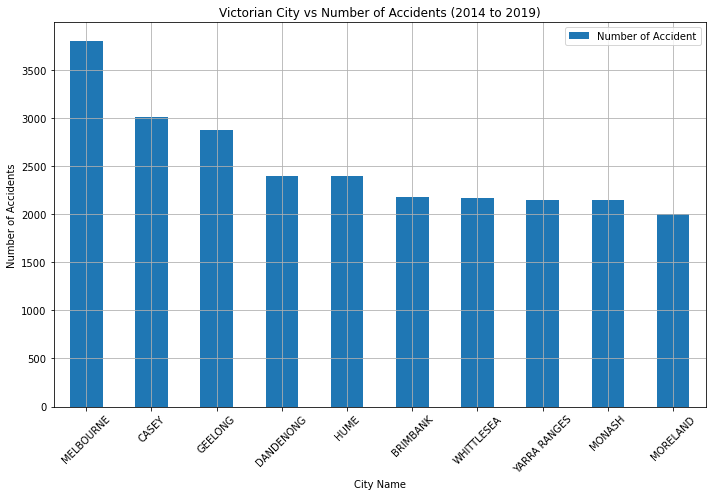

In [23]:
#Plot the information into a bar chat
first_10_chart =first_10_city_df.plot(kind="bar", 
                                 grid=True, 
                                 title="Victorian City vs Number of Accidents (2014 to 2019)", 
                                 figsize=(10,7))
first_10_chart.set_xlabel("City Name")
first_10_chart.set_ylabel("Number of Accidents")
first_10_chart.set_xticklabels(first_10_city_df["index"], rotation = 45)
plt.tight_layout()

In [24]:
# geocoordinates
target_radius = 5000
target_type = "hospital"

# set up a parameters dictionary
params = {"radius": target_radius,
    "type": target_type,
    "key": Api_Key
}

# base url
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
params["location"]= "-37.9848, 145.214"

# run a request using our params dictionary, test the API works
response = requests.get(base_url, params=params)
response_json=response.json()
pprint(response_json)


{'html_attributions': [],
 'next_page_token': 'ATtYBwLh2KHkQaXfNkQavONvisD_SLrq89FEu64BFPtFrpomu35V3CLP8ALD0-JerKDu1gOf7EKWZA3T_-lGwt8UEai6jo6GEHd5JrmeOabaTwHep5lKJEEggC_UFCBYzd4olqIraHbyFZZ9A8fV0RDU-pjpflDW38gRvJeMy3uqyaSW9r8etYf3cVZtIDAB8ZmkysX3Hdt4GQ_nNM6eN-IjLLcC5gszMDprToDYd-_scIzF78D8vdRpdIep_yJ5YwxF-wB-Xjh1E_GHWaPJfKQwG3bYOnEqIIH4WN09KOjfOvT3SBZYy8EGUF_rfAztP2Yklp_RjTsNzHh02GuvXuWP4yi510n9278-1MYCNPlY2aen2GwSMtwLdrRWF1DvpdaDilf-JFPRrht9Qgq1k-vNMsWgFPP3rC_AF69USg3Q4uQftZMk76pxu831yg',
 'results': [{'business_status': 'OPERATIONAL',
              'geometry': {'location': {'lat': -37.97663729999999,
                                        'lng': 145.2184223},
                           'viewport': {'northeast': {'lat': -37.9755067197085,
                                                      'lng': 145.2198239802915},
                                        'southwest': {'lat': -37.9782046802915,
                                                      'lng': 145.2171260197085}}},
    

In [25]:
# Loop throught the dataframe, and call the API to find the nearst medical center in the city
for index, row in first_10_df.iterrows():
    # base url
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    
    lat=row["Latitude"]
    lng=row["Longitude"]
    params["location"] = f"{lat},{lng}"
    response = requests.get(base_url, params=params)
    response_json=response.json()
    results = response_json["results"]
    #pprint(results)
    #print(index)
    
    
    try:
        first_10_df.loc[index, "Closest Medical Centre"] = results[0]["name"]
        first_10_df.loc[index, "Address"] = results[0]["vicinity"]
        print("Finding nearst medical center in " + row["index"])
    except:
        print(row["index"] + " not found!")
        
    print("============================")

Finding nearst medical center in MELBOURNE
Finding nearst medical center in CASEY
Finding nearst medical center in GEELONG
Finding nearst medical center in DANDENONG
HUME not found!
Finding nearst medical center in BRIMBANK
Finding nearst medical center in WHITTLESEA
Finding nearst medical center in YARRA RANGES
Finding nearst medical center in MONASH
Finding nearst medical center in MORELAND


In [26]:
#Display the dataframe with the medical centre name
first_10_df.head(10)

,index,Number of Accident,Latitude,Longitude,Closest Medical Centre,Address
0,MELBOURNE,3803,-37.8136,144.963,Era Health Doctor Melbourne CBD,"Level 9/460 Bourke Street, Melbourne"
1,CASEY,3005,-38.1105,145.292,Blood Bank,"65 Berwick-Cranbourne Road, Cranbourne East"
2,GEELONG,2875,-38.1499,144.362,Dr. Natalie Harrison,"248 Malop Street, Geelong"
3,DANDENONG,2399,-37.9848,145.214,Dandenong Hospital,"135 David Street, Dandenong"
4,HUME,2396,-37.5987,144.829,,
5,BRIMBANK,2181,-37.7595,144.807,Western Health,"Furlong Road, St Albans"
6,WHITTLESEA,2172,-37.5139,145.114,Whittlesea Family Medical Centre,"4 Macmeikan Street, Whittlesea"
7,YARRA RANGES,2147,-37.7451,145.713,Warburton Medical Group,"3476 Warburton Highway, Warburton"
8,MONASH,2142,-37.9016,145.116,Monash Chiropractic Centre,"237 Ferntree Gully Road, Mount Waverley"
9,MORELAND,2005,-37.7241,144.95,Dorset Rehabilitation Centre,"146 Derby Street, Pascoe Vale"


In [27]:
# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Closest Medical Centre}</dd>
<dt>Address</dt><dd>{Address}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
medical_info1 = [info_box_template.format(**row) for index, row in first_10_df.iterrows()]
locations = first_10_df[["Latitude", "Longitude"]]

In [28]:
city = first_10_df["Number of Accident"] / 100

In [29]:
# Plot Heatmap
fig = gmaps.figure(map_type="TERRAIN")

# Create heat layer
#heat_layer = gmaps.heatmap_layer(locations, weights=city, 
#                                 dissipating=False, max_intensity=1000,
#                                 point_radius=0.01)

#Add layer
#fig.add_layer(heat_layer)

# Create symbol layer

symbol_layer = gmaps.marker_layer(locations, hover_text='', 
                      info_box_content=medical_info1 , display_info_box=None, label='')



fig.add_layer(symbol_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [30]:
#========End of Jing's part============

In [ ]:
#======AJ's part =============

In [ ]:
#Creating pie for all the 5 years for the accident types
accident_group = crash_df.groupby('accident_type')['accident_type'].count()
accident_chart = accident_group.plot(kind="pie", y='accident_type', title=("Accident Type Over 5 Years"), 
                                     legend=False, startangle=110, shadow=False, fontsize=10, figsize=(15,9))
plt.savefig("Accident Type Over 5 Years.png")

In [ ]:
#Select only collumn required for Jing's part of analaysis
light_df = crash_df[['accident_no',  'accident_date', 'date_value', 
                      'accident_type',  'dca_code', 
                      'light_condition','longitude', 'latitude', 
                      'lga_name', 'region_name']]
light_df

In [ ]:
light_accid_df = pd.DataFrame(light_df["light_condition"].value_counts())
light_accid_df

In [ ]:
light_accid_df=light_accid_df.rename(columns = {"light_condition" : "No of Accident"})

In [ ]:
light_accid_df.reset_index()

In [ ]:
light_chart =light_accid_df.plot(kind="bar", 
                                 grid=True, 
                                 title="Light Condition vs Number of Accidents (2014 to 2019)", 
                                 figsize=(10,7))
light_chart.set_xlabel("Light Condition")
light_chart.set_ylabel("Number of Accidents")
#plt.tight_layout()

In [ ]:
#creating a dataframe for the region
region_df = crash_df[['accident_no',  'accident_date', 'date_value', 
                      'accident_type',  'dca_code', 
                      'light_condition','longitude', 'latitude', 
                      'lga_name', 'region_name']]

In [ ]:
#creating new dataframe for the region based on the value_counts
region_accid_df = pd.DataFrame(region_df["region_name"].value_counts())
region_accid_df

In [ ]:
#renaming the region name column
region_accid_df= region_accid_df.rename(columns = {"region_name" : "No of Accidents"})

In [ ]:
#plotting on a bar graph 
region_chart =region_accid_df.plot(kind="bar", grid=True, 
                                 title="region vs Number of Accidents (2014 to 2019)", 
                                 figsize=(10,7))
region_chart.set_xlabel("Region")
region_chart.set_ylabel("Number of Accidents")
plt.savefig("region vs Number of Accidents (2014 to 2019.png")

In [ ]:
#creating a new dataframe to show accident_type by region
new_df = crash_df[['accident_no',  'accident_date', 'date_value', 
                      'accident_type',  'dca_code', 
                      'light_condition','longitude', 'latitude', 
                      'lga_name', 'region_name']]


In [ ]:
#grouping the dataframe by accident_type and getting the values for each region
new_region_accid_df = crash_df.groupby("accident_type")['region_name'].value_counts()
new_region_accid_df.head(70)

In [ ]:
#creating a dataframe for suburbs
suburb_df = crash_df[['accident_no',  'accident_date', 'date_value', 
                      'accident_type',  'dca_code', 
                      'light_condition','longitude', 'latitude', 
                      'lga_name', 'region_name']]

In [ ]:
#decalring accident_date as datetime.
suburb_df['accident_date'] =  pd.to_datetime(suburb_df['accident_date'], infer_datetime_format=True)


In [ ]:
#extracting the year from the accident_date column and creating a year column.
suburb_df["year"] = suburb_df['accident_date'].map(lambda x: x.year)
total_accidents = suburb_df.groupby('year')["accident_type"].count()
suburb_df

In [ ]:
accident_chart =total_accidents.plot(kind="bar", 
                                 grid=True, 
                                 title="Total Accidents over 5 years", 
                                 figsize=(15,5))
accident_chart.set_xlabel("year")
accident_chart.set_ylabel("Number of Accidents")

In [ ]:
new_suburb = suburb_df.loc[suburb_df["year"] != 2014]
new_suburb_02 = new_suburb.loc[new_suburb["year"] != 2019]

In [ ]:
#creating accident_rate by groupping the df by year. And getting keys for the years.
accident_rate = new_suburb_02.groupby('year')["accident_type"].count()/ 100
years = accident_rate .keys()
years
accident_rate

In [ ]:
#accident_rate over the 5 year period 
plt.plot(years, accident_rate)
plt.title("Accidents rate over the 5years")
plt.xlabel("years")
plt.ylabel("rate")
plt.savefig("Accidents rate over the 5years.png")

In [ ]:
#created a regression between years and the accident rate but not sure wheather this is correct. 
vc_slope, vc_int, vc_r, vc_p, vc_std_err = stats.linregress(years, accident_rate)
vc_fit =  years * vc_slope + vc_int
plt.scatter(years, accident_rate)
plt.plot(years, vc_fit)
line_eq = "y =" + str(round(vc_slope,2)) + "x +" + str(round(vc_int,2))
plt.annotate(line_eq,(2016, 140), fontsize=15, color="red")
print(f"The r-squared is: {vc_r**2}")
plt.title("Accidents rate over the 5years")
plt.xlabel("years")
plt.ylabel("rate")
plt.savefig("Accidents rate over the 5years_regression.png")
plt.show()

In [ ]:
model = ols('Number of Accident ~ Latitude +  Longitude', data=first_10_df)
fitted_model = model.fit()
fitted_model.summary()